<a href="https://colab.research.google.com/github/shawngraham/palpable_ai/blob/main/Copy_of_Fine_tune_IDEFICS_Vision_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


for context sheet fine-tuning experiment

ok this all seems to work process-wise, but you need better training data. using gemini to generate the training data worked, but the problem of file names has screwed up the first attempt. should do it one image at a time so you can keep track of the names.

system prompt: You generate high-quality training data for image question and answering from scans of archaeological context sheets. It is important to work with highquality extracted text. The meaning of the texts in the scans can be deduced from which boxes the text was entered. Stratigraphic relationships can be inferred by the placement of context numbers in the rows of boxes; the present context will always be in the centre, and other contexts will be entered in stratigraphic relationship above or below as appropriate. Data should be returned in csv format: query, answer. Like so: What are the general easting and northing for this site?,"['443281.71','258449.217']". For each image provided, generate a dozen highquality questions and answers.


--
for the palp stuff, used this prompt to generate dataset, after downloading images from palp.art. Gemini2 experiment for both experiments.

prompt = (
        "Given the following image and text description, generate a set of "
        "question-answer pairs. Focus on aspects related to the image and "
        "text description.\n"
        "Provide multiple answers where appropriate.  Format your output "
        "as a JSON list of dictionaries (e.g. [{'question': '...', 'answers': [...]}])\n"
        "If no questions can be generated, return an empty JSON array: [].\n"
        f"Image Description:\n{text_description}\n\n"
        "Image:\n"
    )

see palp_to_ai.ipynb. duplicate, rejig for context sheet experiment?


https://huggingface.co/docs/transformers/main/en/model_doc/idefics2

code needs to be tidied; also check with CB for best place to rent some training time


#### Step 1: Install libraries and dependencies.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q accelerate datasets peft bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#!unzip archaepdfs.zip
!unzip downloaded_images.zip

In [3]:
#remove dot files in the unzipped folder, which is a problem mostly for mac users but not always

import os

def remove_dot_files(directory):
  for filename in os.listdir(directory):
    if filename.startswith('.'):
      filepath = os.path.join(directory, filename)
      try:
        if os.path.isfile(filepath):
          os.remove(filepath)
        elif os.path.isdir(filepath):
          # Handle directories if needed (e.g., recursively remove contents)
          # For simplicity, this example only removes files.
          pass
        print(f"Removed: {filepath}")
      except OSError as e:
        print(f"Error removing {filepath}: {e}")

remove_dot_files("downloaded_images")

In [5]:
import csv

def find_csv_formatting_errors(csv_file_path):
    """
    Identifies and reports row number errors related to inconsistent column counts in a CSV file.

    Args:
      csv_file_path: The path to the CSV file.

    Returns:
      A list of dictionaries, where each dictionary represents an error. Each dictionary
      has the following keys:
        - 'row_number': The 1-indexed row number where the error occurred.
        - 'expected_columns': The number of columns expected based on the header row.
        - 'actual_columns': The number of columns found in the erroneous row.
        - 'row_content': The full row content as a string.
      Returns an empty list if no errors are found.
    """
    errors = []
    try:
        with open(csv_file_path, 'r', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader, None)  # Read the header row, if exists
            if header is None:
              return errors #if no header we assume 0 rows and return an empty list
            expected_columns = len(header)

            for row_number, row in enumerate(reader):
                actual_columns = len(row)
                if actual_columns != expected_columns:
                    errors.append({
                        'row_number': row_number + 1,  # 1-indexed for user readability
                        'expected_columns': expected_columns,
                        'actual_columns': actual_columns,
                        'row_content': ','.join(row),
                    })
    except FileNotFoundError:
        print(f"Error: File not found: {csv_file_path}")
        return None #return None to indicate file error
    except Exception as e:
      print(f"An error occurred: {e}")
      return None
    return errors

#usage
if __name__ == '__main__':

  csv_file_path = '/content/artemis_cup_theseus_qa_pairs_correct.csv'

  error_results = find_csv_formatting_errors(csv_file_path)

  if error_results is None:
    print("There was an error reading the file.")
  elif error_results:
    for error in error_results:
      print(f"Error in row {error['row_number']}:")
      print(f"  Expected {error['expected_columns']} columns, but found {error['actual_columns']}.")
      print(f"  Row content: {error['row_content']}")
  else:
      print("No formatting errors detected.")

No formatting errors detected.


#### Step 2: Create Dataset (optional)

In [ ]:
# Clone repository if you want to work with his data
#!git clone https://github.com/NSTiwari/Fine-tune-IDEFICS-Vision-Language-Model.git

Cloning into 'Fine-tune-IDEFICS-Vision-Language-Model'...
remote: Enumerating objects: 718, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 718 (delta 6), reused 17 (delta 5), pack-reused 699
Receiving objects: 100% (718/718), 147.38 MiB | 33.38 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (1203/1203), done.


In [7]:
from datasets import Dataset, DatasetDict, Image
import pandas as pd
import os

TRAIN_SAMPLES = 1000
TEST_SAMPLES = 200
TEST_SIZE = 0.166

# Define the directory containing the images.
#train_images_directory = '/content/train/'
train_images_directory = '/content/downloaded_images'
test_images_directory = '/content/test/'

# Read the CSV Q&A text.
#qa_text = pd.read_csv('/content/qa_text.csv')
qa_text = pd.read_csv('/content/artemis_cup_theseus_qa_pairs_correct.csv')


# Get the list of ids from the csv, which we'll use to match filenames
ids_from_csv = qa_text['id'].tolist()

print(ids_from_csv)

# Create a mapping between ids from csv and filenames
image_paths = []
for file_id in ids_from_csv:
    # Try to find the image in the training directory.
    image_path = os.path.join(train_images_directory, f'{file_id}.jpg')
    if os.path.exists(image_path):
        image_paths.append(image_path)
        continue #move on to next id
    # if it's not found in the training directory, check the test directory
    image_path = os.path.join(test_images_directory, f'{file_id}.jpg')
    if os.path.exists(image_path):
        image_paths.append(image_path)
        continue #move on to next id
    # Special case: check for summary.png in training directory
    if file_id == "summary":
         image_path = os.path.join(train_images_directory, f'summary.jpg')
         if os.path.exists(image_path):
            image_paths.append(image_path)
            continue #move on to next id
    # If none of the above, raise error
    raise ValueError(f"Could not find a relevant image file for {file_id} from csv id")

# Create a list of other columns such as id, query, and answer.
ids = ids_from_csv
#queries = qa_text['query'].tolist()
queries = qa_text['query'].tolist()
answers = qa_text['answers'].tolist()

# Create the dataset dictionary
dataset_dict = {
    'id': ids,
    'image': image_paths,
    'query': queries,
    'answers': answers
}

# Create the dataset.
dataset = Dataset.from_dict(dataset_dict)

# Cast the 'image' column to Image type.
dataset = dataset.cast_column("image", Image())

# Split the dataset into train and test.
split_dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=False)

print(split_dataset)



['0013.01', '0013.01', '0013.01', '0013.01', '0013.01', '0013.01', '0013.01', '0013.01', 'image10861', 'image10861', 'image10861', 'image10861', 'image10861', 'image10861', 'image10861', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11218', 'image11252', 'image11252', 'image11252', 'image11252', 'image11252', 'image11252', 'image11252', 'image11913', 'image11913', 'image11913', 'image11913', 'image11913', 'image11913', 'image11913', 'image11913', 'image12036', 'image12036', 'image12036', 'image12036', 'image12036', 'image12440', 'image12440', 'image12440', 'image12440', 'image12440', 'image12440', 'image12494', 'image12494', 'image12494', 'image12494', 'image12498', 'image12498', 'image12498', 'image12498', 'image12498', 'image12951', 'image12951', 'image12951', 'image12951', 'image12951', 'image12951', 'image12951', 'image13064', '

In [2]:
#and I'll take a moment here to try to format the same data but for use for finetuning a pixtral model via the unsloth.ai notebooks
from datasets import Dataset, DatasetDict, Image
import pandas as pd
import os
import json
import ast

TRAIN_SAMPLES = 1000
TEST_SAMPLES = 200
TEST_SIZE = 0.166

# Define the directory containing the images.
train_images_directory = '/content/downloaded_images'
test_images_directory = '/content/test/'

# Read the CSV Q&A text.
qa_text = pd.read_csv('/content/artemis_cup_theseus_qa_pairs_correct.csv')

# Get the list of ids from the csv, which we'll use to match filenames
ids_from_csv = qa_text['id'].tolist()

# Create a mapping between ids from csv and filenames
image_paths = []
for file_id in ids_from_csv:
    # Try to find the image in the training directory.
    image_path = os.path.join(train_images_directory, f'{file_id}.jpg')
    if os.path.exists(image_path):
        image_paths.append(image_path)
        continue #move on to next id
    # if it's not found in the training directory, check the test directory
    image_path = os.path.join(test_images_directory, f'{file_id}.jpg')
    if os.path.exists(image_path):
        image_paths.append(image_path)
        continue #move on to next id
    # Special case: check for summary.jpg in training directory
    if file_id == "summary":
         image_path = os.path.join(train_images_directory, f'summary.jpg')
         if os.path.exists(image_path):
            image_paths.append(image_path)
            continue #move on to next id
    # If none of the above, raise error
    raise ValueError(f"Could not find a relevant image file for {file_id} from csv id")

# Create a list of other columns such as id, query, and answer.
ids = ids_from_csv
queries = qa_text['query'].tolist()
answers = qa_text['answers'].tolist()

# Convert answers to lists
answers = [ast.literal_eval(ans) for ans in answers]

# Prepare the data in the required format
formatted_data = []
for i in range(len(ids)):
    formatted_data.append({
        "role": "user",
        "content": [
            {"type": "text", "text": queries[i]},
            {"type": "image", "image": image_paths[i]}
        ]
    })
    formatted_data.append({
        "role": "assistant",
        "content": [
            {"type": "text", "text": answers[i][0]} #take the first answer only
        ]
    })


# Create the dataset.
dataset = Dataset.from_list(formatted_data)


# Correctly cast image paths
dataset = dataset.cast_column("image", Image())



# Split the dataset into train and test.
split_dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=False)


print(split_dataset)


# Save the dataset to a json for manual inspection
with open("formatted_dataset.json", "w") as outfile:
    json.dump(split_dataset, outfile, indent=4, default=str)

DatasetDict({
    train: Dataset({
        features: ['role', 'content', 'image'],
        num_rows: 6560
    })
    test: Dataset({
        features: ['role', 'content', 'image'],
        num_rows: 1306
    })
})


#### Step 3: Push the dataset on Hugging Face Hub (optional)

In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
split_dataset.push_to_hub("sgraham/pixtral_QA_palp_test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/6560 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/66 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1306 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/586 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/sgraham/pixtral_QA_palp_test/commit/4677d8bb078bb2bc0c68b06de9c07bbf3eb7853c', commit_message='Upload dataset', commit_description='', oid='4677d8bb078bb2bc0c68b06de9c07bbf3eb7853c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/sgraham/pixtral_QA_palp_test', endpoint='https://huggingface.co', repo_type='dataset', repo_id='sgraham/pixtral_QA_palp_test'), pr_revision=None, pr_num=None)

#### Step 4: Load the dataset

In [3]:
from datasets import load_dataset

#train_dataset = load_dataset("sgraham/DocumentIDEFICS_QA_archae_test", split="train")
#eval_dataset = load_dataset("sgraham/DocumentIDEFICS_QA_archae_test", split="test")
train_dataset = load_dataset("sgraham/DocumentIDEFICS_QA_palp_test", split="train")
eval_dataset = load_dataset("sgraham/DocumentIDEFICS_QA_palp_test", split="test")

README.md:   0%|          | 0.00/489 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3377 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/673 [00:00<?, ? examples/s]

Inspect the training data

In [4]:
train_dataset[66]

{'id': 'image12951',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x288>,
 'query': 'Describe the wall painting style according to the provided text.',
 'answers': "['Yellow-painted walls with three panels each', 'A yellow frieze', 'A red lower dado', 'A painting in the middle of each central panel']"}

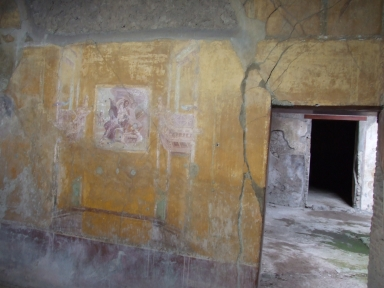

In [6]:
train_dataset[66]['image']

#### Step 5: Configure LoRA adapters

In [7]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True

processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.jinja' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

In [8]:
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # This works for A100 or H100
    ).to(DEVICE)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

#### Step 6: Create Data Collator for IDEFICS2 format.

In [9]:
import random
import ast

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"].convert("RGB") # my images are greyscale
            question = example["query"]
            # Check if the answer is already a list or needs to be converted
            answer = example["answers"]
            # if the answer is an integer, wrap it in a list to make random.choice work
            if isinstance(answer, int):
                answer = [answer]
            elif isinstance(answer, str):
                answer = ast.literal_eval(answer)
            if not isinstance(answer, list):
                answer = [answer] # handles the case where answer is a single int or str

            #Now the answer should always be a list
            answer = random.choice(answer)

            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Answer briefly."},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(
                messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images,
                          return_tensors="pt", padding=True)
        labels = batch.input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        labels[labels == model.config.image_token_id] = -100
        batch["labels"] = labels
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        return batch

data_collator = MyDataCollator(processor)

#### Step 7: Setup training parameters

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "IDEFICS_DocVQA_1",
    learning_rate = 1e-4,
    fp16 = True,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 8,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    evaluation_strategy ="steps",
    save_strategy = "steps",
    eval_steps = 10,
    save_steps = 25,
    max_steps = 30,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)

# training_args = TrainingArguments(
#     output_dir="IDEFICS3_DocVQA",
#     learning_rate=2e-4,
#     fp16=True,
#     per_device_train_batch_size=3,
#     per_device_eval_batch_size=3,
#     gradient_accumulation_steps=8,
#     dataloader_pin_memory=False,
#     save_total_limit=3,
#     evaluation_strategy="steps",
#     save_strategy="steps",
#     eval_steps=25,
#     save_steps=25,
#     max_steps=1000,
#     logging_steps=5,
#     remove_unused_columns=False,
#     push_to_hub=False,
#     label_names=["labels"],
#     load_best_model_at_end=True,
#     report_to="none",
#     optim="paged_adamw_8bit",
# )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset
)

#### Step 8: Start Training

In [12]:
trainer.train()

Step,Training Loss,Validation Loss
10,3.592500,2.842739
20,1.398800,1.348348
30,1.249500,1.275290


TrainOutput(global_step=30, training_loss=2.3805665016174316, metrics={'train_runtime': 1033.9143, 'train_samples_per_second': 0.464, 'train_steps_per_second': 0.029, 'total_flos': 2689832869002048.0, 'train_loss': 2.3805665016174316, 'epoch': 0.14209591474245115})

#### Step 9: Evaluate the model

In [13]:
eval_dataset

Dataset({
    features: ['id', 'image', 'query', 'answers'],
    num_rows: 673
})

In [28]:
test_example = eval_dataset[66]
test_example

{'id': 'PPM8_1462',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=361x384>,
 'query': 'What is the significance of the preparatory graffiti?',
 'answers': '["It reveals the artist\'s preliminary sketches or outlines.", \'It shows the process of creating the artwork.\', \'It helps determine the execution technique.\']'}

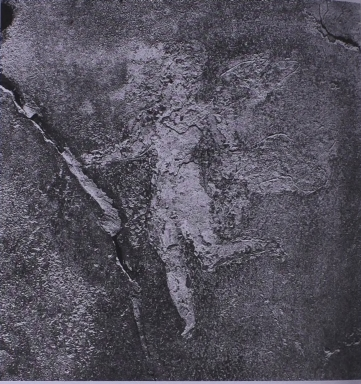

In [29]:
test_example["image"]

In [30]:
model.eval()

image = test_example["image"]
query = test_example["query"]
print(query)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Think first, then give your best answer."},
            {"type": "image"},
            {"type": "text", "text": query}
        ]
    }
]


text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)

# Move inputs to the same device as the model
inputs = inputs.to(DEVICE)  # This line is added

generated_ids = model.generate(**inputs, max_new_tokens=64)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
print(generated_texts)

What is the significance of the preparatory graffiti?
['It provides insight into the artistic process and the development of the final artwork.']


#### Step 10: Push the model on Hugging Face

In [31]:
from huggingface_hub import whoami
from pathlib import Path

# Output directory.
output_dir = "IDEFICS_DocVQA_1"
repo_name = "IDEFICS2-DocVQA-fine-tuned-PALP"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{repo_name}"

In [32]:
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id


upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="Pushed the IDEFICS2 fine-tuned model on some archae context sheets just to figure out the workflow.",
    ignore_patterns=["step_*", "epoch_*"],
)

optimizer.pt:   0%|          | 0.00/48.1M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Upload 10 LFS files:   0%|          | 0/10 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/48.1M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sgraham/IDEFICS2-DocVQA-fine-tuned-PALP/commit/f38ac8ce955f0c461d84b4c8c39d20194ab0b1e5', commit_message='Pushed the IDEFICS2 fine-tuned model on some archae context sheets just to figure out the workflow.', commit_description='', oid='f38ac8ce955f0c461d84b4c8c39d20194ab0b1e5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sgraham/IDEFICS2-DocVQA-fine-tuned-PALP', endpoint='https://huggingface.co', repo_type='model', repo_id='sgraham/IDEFICS2-DocVQA-fine-tuned-PALP'), pr_revision=None, pr_num=None)

In [33]:
## actually, this is for the complete model:
from transformers import IdeficsForVisionText2Text, AutoProcessor
from huggingface_hub import whoami, upload_folder, create_repo

# First, save the model and processor properly
def save_model(model, processor, output_dir):
    """Save the model and processor with all necessary files"""
    model.save_pretrained(output_dir)
    processor.save_pretrained(output_dir)

# Then push to Hugging Face
output_dir = "IDEFICS_DocVQA_1"
repo_name = "IDEFICS2-DocVQA-fine-tuned-PALP"

# Assuming you have your fine-tuned model in a variable called 'model'
# and processor in a variable called 'processor'
save_model(model, processor, output_dir)

# Now push to Hugging Face
username = whoami()["name"]
repo_id = f"{username}/{repo_name}"

# Create or get existing repo
repo_id = create_repo(
    repo_id=repo_id,
    exist_ok=True,
    private=False
).repo_id

# Upload the complete model
uploaded_files = upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="Pushing complete fine-tuned model with all necessary files"
)

print(f"Successfully uploaded to: https://huggingface.co/{repo_id}")


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

Successfully uploaded to: https://huggingface.co/sgraham/IDEFICS2-DocVQA-fine-tuned-PALP


In [30]:
!unzip random-images.zip

Archive:  random-images.zip
   creating: random-images/
  inflating: random-images/image41174.jpg  
  inflating: __MACOSX/random-images/._image41174.jpg  
  inflating: random-images/image34152.jpg  
  inflating: __MACOSX/random-images/._image34152.jpg  
  inflating: random-images/image58926.jpg  
  inflating: __MACOSX/random-images/._image58926.jpg  
  inflating: random-images/image50065.jpg  
  inflating: __MACOSX/random-images/._image50065.jpg  


In [32]:
from PIL import Image #Import from PIL, not datasets


## a function to let you ask one question at a time of the images.
## ugly, but ok

def process_new_images(model, processor, image_dir):
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):  ## pay attention to file endings! Should modify this for multiple file types
            filepath = os.path.join(image_dir, filename)
            try:
                # Correctly open the image using PIL
                image = Image.open(filepath).convert("RGB")
                query = input(f"Enter question for {filename}: ")  #Get question from user
                messages = [
                    {"role": "user", "content": [{"type": "text", "text": "Give your best answer."}, {"type": "image"}, {"type": "text", "text": query}]}
                ]
                text = processor.apply_chat_template(messages, add_generation_prompt=True)
                inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True).to(DEVICE)
                generated_ids = model.generate(**inputs, max_new_tokens=64)
                generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
                print(f"Answer for {filename}: {generated_texts[0]}")
            except FileNotFoundError:
                print(f"Error: Image file not found: {filepath}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

#


In [33]:
#process_new_images(model, processor, "/content/test")
process_new_images(model, processor, "/content/random-images")

Enter question for image41174.jpg: what style is is
Answer for image41174.jpg: Roman wall painting
Enter question for image34152.jpg: what style is this
Answer for image34152.jpg: Roman wall painting
Enter question for image58926.jpg: what colours are there
Answer for image58926.jpg: Red
Enter question for image50065.jpg: how many giraffes
Answer for image50065.jpg: 0


In [39]:
## a function to ask one question of every image in a folder
import os

def process_images(model, processor, image_dir, question):
    all_answers = {} #Use a dictionary to store answers with filenames as keys.
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"): ### file endings!!
            filepath = os.path.join(image_dir, filename)
            try:
                image = Image.open(filepath).convert("RGB")
                messages = [
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": f"Give your best answer to the following question: '{question}'"},
                            {"type": "image"},
                        ]
                    }
                ]
                text = processor.apply_chat_template(messages, add_generation_prompt=True)
                inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True).to(DEVICE)
                generated_ids = model.generate(**inputs, max_new_tokens=64)
                generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
                all_answers[filename] = generated_texts[0] #Store answer with filename
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                all_answers[filename] = f"Error processing {filename}: {e}" #Store error message

    return all_answers

#usage
image_directory = "/content/"
question_to_ask = "Write a high-quality caption for the image, describing art work in detail."
individual_answers = process_images(model, processor, image_directory, question_to_ask)

# Print the answers
for filename, answer in individual_answers.items():
    print(f"\nImage: {filename}\nAnswer: {answer}")


Image: image37540.jpg
Answer: A small, dark room with a single, faded painting on the wall.


In [34]:
!wget http://umassamherst.lunaimaging.com/MediaManager/srvr?mediafile=/Size3/umass~14~14/4222/image37540.jpg

--2025-01-09 21:04:00--  http://umassamherst.lunaimaging.com/MediaManager/srvr?mediafile=/Size3/umass~14~14/4222/image37540.jpg
Resolving umassamherst.lunaimaging.com (umassamherst.lunaimaging.com)... 35.202.207.80
Connecting to umassamherst.lunaimaging.com (umassamherst.lunaimaging.com)|35.202.207.80|:80... connected.
HTTP request sent, awaiting response... 200 200
Length: 330902 (323K) [image/jpeg]
Saving to: ‘srvr?mediafile=%2FSize3%2Fumass~14~14%2F4222%2Fimage37540.jpg’

srvr?mediafile=%2FS 100%[===================>] 323.15K   457KB/s    in 0.7s    

2025-01-09 21:04:01 (457 KB/s) - ‘srvr?mediafile=%2FSize3%2Fumass~14~14%2F4222%2Fimage37540.jpg’ saved [330902/330902]



In [35]:
from transformers import IdeficsForVisionText2Text, AutoProcessor
import torch
from PIL import Image

def load_model(repo_id):
    """Load the fine-tuned IDEFICS model and processor"""
    model = IdeficsForVisionText2Text.from_pretrained(
        repo_id,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    processor = AutoProcessor.from_pretrained(repo_id)
    return model, processor

def generate_caption(model, processor, image_path, prompt="<image>Describe this image in detail:", max_length=100):
    """Generate a caption for a given image"""
    # Load and preprocess the image
    image = Image.open(image_path)

    # Prepare inputs
    inputs = processor(
        prompt,
        images=[image],
        return_tensors="pt",
    ).to(model.device)

    # Generate caption
    generated_ids = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        num_return_sequences=1
    )

    # Decode and return the generated caption
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text



In [36]:
# Generate caption for a new image
image_path = "image37540.jpg"  # Replace with your image path
caption = generate_caption(model, processor, image_path)
print(f"Generated caption: {caption}")


TypeError: Idefics2Processor.__call__() got multiple values for argument 'images'